In [1]:
# import libraries
import pandas as pd
import numpy as np
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

import random

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [2]:
def get_image_info(dirname):
    
    # initialise list to keep image info
    im_info = []
    
    # get all team folders
    teams = [f.name for f in os.scandir(dirname) if f.is_dir()]
    
    # iterate over each team folder
    for team in list(teams):
        
        # create team directory
        teams_dir = os.path.join(dirname,team)
        
        # get all players for that team
        players = [f.name for f in os.scandir(teams_dir) if f.is_dir()]
        
        # iterate over each player
        for player in list(players):
            
            # create player directory
            player_dir = os.path.join(dirname,team,player)
            
            # get all images for that player
            images = [f.name for f in os.scandir(player_dir)]
            
            # iterate over all images
            for image in images:
                
                # get the image path
                impath = os.path.join(dirname,team,player,image)
                
                # store image info in dict
                im_dict = {'Team':team, 'Player': player, 'Image':image, 'Path': impath}
                
                # append to image info list
                im_info.append(im_dict)
    
    # create dataframe from image info list
    df = pd.DataFrame(im_info)
    
    # return dataframe
    return df

In [3]:
# get dataframe containing image info
df = get_image_info('part1')
df = df.iloc[:500]
# number of images
num_ims = len(df)

In [4]:
df

,Team,Player,Image,Path
0,bristol,person_11,0.jpg,part1\bristol\person_11\0.jpg
1,bristol,person_11,1.jpg,part1\bristol\person_11\1.jpg
2,bristol,person_11,10.jpg,part1\bristol\person_11\10.jpg
3,bristol,person_11,11.jpg,part1\bristol\person_11\11.jpg
4,bristol,person_11,12.jpg,part1\bristol\person_11\12.jpg
...,...,...,...,...
495,bristol,person_25,32.jpg,part1\bristol\person_25\32.jpg
496,bristol,person_25,33.jpg,part1\bristol\person_25\33.jpg
497,bristol,person_25,34.jpg,part1\bristol\person_25\34.jpg
498,bristol,person_25,35.jpg,part1\bristol\person_25\35.jpg


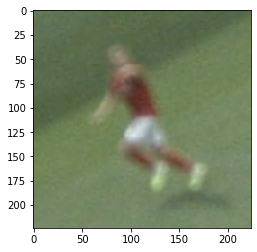

In [5]:
# plot random image
ind = random.randint(0,num_ims)

image_path = df['Path'].iloc[ind]

img = imread(image_path)

plt.figure()

plt.imshow(img)

In [6]:
image_data = []

# read in all images
for image_path in df['Path']:

    img = imread(image_path)
    
    image_data.append(img)

In [7]:
input_data = np.asarray(image_data)

In [8]:
input_data.shape

(500, 224, 224, 3)

In [9]:
label_data = df['Player'].values

In [10]:
label_data

array(['person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'person_11',
       'person_11', 'person_11', 'person_11', 'person_11', 'pers

In [11]:
len(np.unique(label_data))

6

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        #self.conv2 = nn.Conv2d(6, 8, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(6 * 112 * 112, 84)
        #self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.pool(F.relu(self.conv2(x)))
        #print(x.size())
        x = x.view(-1,6 * 112 * 112)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(input_data, label_data, test_size = 0.3,random_state=42)

train_x_shape = train_x.shape
train_y_shape = train_y.shape
val_x_shape = train_x.shape
val_y_shape = val_y.shape

train_x_shape

(350, 224, 224, 3)

In [15]:
type(train_y[0])

str

In [16]:
# converting training images into torch format
train_x  = torch.from_numpy(train_x).float()
val_x  = torch.from_numpy(val_x).float()

# encode labels
le = preprocessing.LabelEncoder()
targets = le.fit_transform(list(train_y))
# converting the target into torch format
train_y = torch.from_numpy(targets).long()
# encode validation labels
val_y = le.transform(list(val_y))
val_y = torch.from_numpy(val_y).long()

# transform shape
train_x = train_x.transpose(1,3)
val_x = val_x.transpose(1,3)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([350, 3, 224, 224]), torch.Size([350]))

In [17]:
type(train_y[0])

torch.Tensor

In [18]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train = Variable(train_x)
    y_train =  Variable(train_y)
    # getting the validation set
    x_val = Variable(val_x)
    y_val = Variable(val_y)


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [19]:
# defining the number of epochs
n_epochs = 15
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(4.8300, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(3.3195, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(1.7656, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(1.7757, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.7815, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(1.7837, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.7815, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.7732, grad_fn=<NllLossBackward>)


In [20]:
train_losses

[tensor(5.6693, grad_fn=<NllLossBackward>),
 tensor(215.2779, grad_fn=<NllLossBackward>),
 tensor(4.2283, grad_fn=<NllLossBackward>),
 tensor(1.7934, grad_fn=<NllLossBackward>),
 tensor(1.7857, grad_fn=<NllLossBackward>),
 tensor(1.7745, grad_fn=<NllLossBackward>),
 tensor(1.7655, grad_fn=<NllLossBackward>),
 tensor(1.7636, grad_fn=<NllLossBackward>),
 tensor(1.7618, grad_fn=<NllLossBackward>),
 tensor(1.7596, grad_fn=<NllLossBackward>),
 tensor(1.7569, grad_fn=<NllLossBackward>),
 tensor(1.7538, grad_fn=<NllLossBackward>),
 tensor(1.7501, grad_fn=<NllLossBackward>),
 tensor(1.7458, grad_fn=<NllLossBackward>),
 tensor(1.7402, grad_fn=<NllLossBackward>)]

In [21]:
val_losses

[tensor(4.8300, grad_fn=<NllLossBackward>),
 tensor(222.4660, grad_fn=<NllLossBackward>),
 tensor(3.3195, grad_fn=<NllLossBackward>),
 tensor(1.7599, grad_fn=<NllLossBackward>),
 tensor(1.7656, grad_fn=<NllLossBackward>),
 tensor(1.7714, grad_fn=<NllLossBackward>),
 tensor(1.7757, grad_fn=<NllLossBackward>),
 tensor(1.7791, grad_fn=<NllLossBackward>),
 tensor(1.7815, grad_fn=<NllLossBackward>),
 tensor(1.7831, grad_fn=<NllLossBackward>),
 tensor(1.7837, grad_fn=<NllLossBackward>),
 tensor(1.7832, grad_fn=<NllLossBackward>),
 tensor(1.7815, grad_fn=<NllLossBackward>),
 tensor(1.7783, grad_fn=<NllLossBackward>),
 tensor(1.7732, grad_fn=<NllLossBackward>)]

In [22]:
conv_layer = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (3,3), stride = 1, padding=1)

In [23]:
x = torch.randn((100,6,224,224))
conv_layer(x).size()

torch.Size([100, 16, 224, 224])

In [24]:
x_in = torch.randn(100,16,224,224)
pool_layer = nn.MaxPool2d(2, 2)

In [25]:
pool_layer(x_in).size()

torch.Size([100, 16, 112, 112])

In [26]:
outputs = model(train_x)

In [27]:
_, predicted = torch.max(outputs, 1)

In [28]:
predicted

tensor([4, 0, 1, 4, 0, 4, 0, 0, 1, 0, 0, 4, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 4, 0, 0, 1, 4, 1, 0, 0, 4, 1, 1, 1, 0, 4, 4, 1, 1, 1, 0, 0,
        0, 0, 4, 1, 0, 1, 1, 1, 1, 0, 1, 0, 4, 1, 4, 4, 4, 0, 0, 4, 0, 0, 0, 1,
        0, 1, 0, 4, 4, 0, 1, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 4, 0, 1, 0, 0, 0, 4,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 4, 1, 0, 1, 0, 0, 4, 0,
        1, 0, 4, 0, 0, 4, 0, 1, 1, 1, 1, 1, 0, 1, 0, 4, 1, 1, 1, 1, 1, 1, 4, 1,
        0, 1, 1, 1, 4, 1, 4, 1, 1, 0, 0, 1, 0, 1, 0, 0, 4, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 4, 4, 1, 0, 1, 1, 0, 0,
        4, 4, 0, 1, 1, 0, 1, 1, 4, 4, 1, 1, 0, 4, 1, 4, 1, 1, 4, 0, 1, 0, 1, 4,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 4, 0, 1, 3, 0, 0, 1, 0, 0, 1, 4,
        1, 1, 0, 0, 1, 4, 1, 1, 0, 0, 3, 0, 0, 1, 1, 1, 0, 0, 4, 4, 0, 1, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,

In [29]:
train_y

tensor([0, 1, 0, 0, 5, 4, 0, 1, 4, 0, 1, 4, 5, 0, 5, 5, 0, 0, 5, 1, 0, 1, 5, 1,
        1, 1, 4, 1, 1, 4, 4, 1, 4, 2, 5, 1, 4, 0, 1, 1, 5, 4, 4, 2, 1, 1, 1, 0,
        1, 4, 5, 0, 1, 1, 1, 1, 1, 0, 5, 4, 1, 1, 3, 3, 1, 4, 4, 1, 4, 1, 4, 2,
        0, 1, 1, 4, 1, 5, 2, 0, 1, 0, 5, 0, 4, 4, 4, 1, 1, 1, 4, 1, 5, 0, 4, 1,
        0, 0, 4, 1, 5, 2, 5, 1, 3, 4, 1, 4, 1, 5, 2, 1, 4, 1, 1, 1, 5, 1, 4, 1,
        1, 1, 1, 3, 3, 4, 4, 4, 2, 1, 3, 1, 4, 1, 1, 4, 2, 5, 4, 2, 4, 2, 4, 4,
        1, 1, 3, 5, 5, 5, 4, 1, 3, 1, 1, 1, 2, 1, 1, 1, 4, 1, 4, 4, 1, 2, 4, 1,
        4, 4, 1, 5, 0, 5, 0, 2, 0, 1, 1, 4, 1, 0, 0, 0, 1, 1, 4, 4, 1, 1, 0, 1,
        5, 4, 1, 0, 5, 4, 1, 2, 1, 4, 0, 2, 5, 1, 1, 5, 1, 1, 1, 2, 1, 0, 0, 0,
        2, 4, 1, 5, 0, 4, 1, 2, 2, 1, 4, 1, 0, 1, 1, 5, 0, 4, 5, 0, 3, 0, 1, 0,
        4, 5, 4, 1, 2, 5, 5, 4, 1, 1, 1, 2, 5, 1, 5, 5, 3, 4, 2, 1, 1, 0, 1, 4,
        1, 3, 2, 1, 0, 4, 0, 5, 5, 0, 4, 0, 1, 0, 2, 5, 4, 0, 4, 5, 0, 4, 2, 1,
        0, 4, 0, 4, 2, 1, 4, 5, 1, 3, 5,

In [30]:
accuracy_score(train_y, predicted)

0.3457142857142857

In [31]:
outputs_val = model(val_x)
_, predicted_val = torch.max(outputs_val, 1)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:73] data. DefaultCPUAllocator: not enough memory: you tried to allocate 180633600 bytes. Buy new RAM!

In [ ]:
val_y

In [ ]:
predicted_val

In [ ]:
accuracy_score(val_y, predicted_val)